# Proyecto 1

Natalia Isabel Padilla Terrones 173716

Lorena Patricia Barrera Rodríguez 164694

## Preguntas

### Variable target
La variable target en este modelo es **churn** o **no churn**, es decir que el objetivo del modelo es determinar si el cliente abandonará la empresa o seguirá siendo cliente; por lo tanto, la etiqueta positiva es churn.

En este contexto:
- Un **positivo verdadero** (TP) es si el modelo detecta que un cliente va a churnear y, efectivamente, churnea
- Un **negativo verdadero** (TN) es si el modelo detecta que un cliente no va a churnear y, efectivamente, no churnea
- Un **falso positivo** (FP) es si el modelo detecta que un cliente va a churnear, pero al final no lo hace
- Un **falso negativo** (FN) es si el modelo detecta que un cliente no va a churnear, pero al final sí lo hace

Para esa situación, es preferible **minimizar los falsos negativos** ya que los costos asociados son mayores en este escenario. Si el modelo predice que un cliente no va a churnear y al final sí lo hace, la empresa estaría perdiendo más clientes de los contemplados, generando un costo extra al hacer un ajuste en otros aspectos del negocio. Además, claramente se estaría perdiendo el pago de este cliente que abandona. Consideramos que es más costoso para Telco perder un cliente que no estaba previsto, a hacer alguna campaña o generar incentivos para que un cliente previsto para abandonar no abandone, y al final no fuera a abandonar desde un principio.
Para poder cumplir con lo dicho anteriormente, la métrica que se necesita optimizar es el **_recall._**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/NataliaPadilla/.pyenv/versions/itam_md/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Se lee la base de datos
empresa = pd.read_csv("~/Documents/ITAM/Primavera2021/MD/Customer-Churn.csv")

In [3]:
empresa.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Limpieza de datos

In [4]:
empresa.rename(columns={'customerID': 'customer_id', 'SeniorCitizen':'senior_citizen', 
                        'Partner':'partner', 'Dependents':'dependents', 'PhoneService':'phone_service',
                        'MultipleLines':'multiple_lines', 'InternetService':'internet_service',
                        'OnlineSecurity':'online_security', 'OnlineBackup':'online_backup',
                        'DeviceProtection':'device_protection', 'TechSupport':'tech_support',
                        'StreamingTV':'streaming_tv', 'StreamingMovies':'streaming_movies',
                        'Contract':'contract', 'PaperlessBilling':'paperless_billing', 
                        'PaymentMethod':'payment_method', 'MonthlyCharges':'monthly_charges',
                        'TotalCharges':'total_charges', 'Churn':'churn'}, inplace=True)


In [5]:
empresa.customer_id.count()

7043

In [6]:
empresa.replace(' ', np.nan, inplace = True)
empresa.dropna(inplace = True)
empresa.reset_index(drop=True, inplace=True)
empresa.customer_id.count()

7032

## Data profiling de las variables total_charges y la variable contract interpreta la salida.



Se analizan los datos de las columnas:

In [7]:
# Tipos de las variables
empresa.dtypes

customer_id           object
gender                object
senior_citizen         int64
partner               object
dependents            object
tenure                 int64
phone_service         object
multiple_lines        object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
contract              object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges         object
churn                 object
dtype: object

Ambas variables son categóricas, por lo tanto se crea una función para obtener los datos relevantes:

In [8]:
# Función para ver el data profiling
def category_profiling(df, col, profiling_dict):
    """
    Profiling for categoric columns. 
    
    :param: column to analyze
    :return: dictionary
    """
    profiling = {}

    profiling.update({'mode': df[col].mode()[0],
                     'num_categories': df[col].nunique(),
                     'categories': df[col].unique(),
                     #'uniques': df[col].nunique(),
                     'missings': sum(df[col].isna())/df[col].size*100,
                     'top1_repeated': get_repeated_values(df, col, 1),
                     'top2_repeated': get_repeated_values(df, col, 2),
                     'top3_repeated': get_repeated_values(df, col, 3)})
    
    profiling_dict.update({col: profiling})
    
    return profiling_dict

Se hace el data profiling de ambas variables:

In [9]:
def get_repeated_values(df, col, top):
    top_5 = df.groupby([col])[col]\
                    .count()\
                    .sort_values(ascending = False)\
                    .head()
    indexes_top_5 = top_5.index
    
    if ((top == 1) and (len(indexes_top_5) > 0)):
        return indexes_top_5[0]
    elif ((top == 2) and (len(indexes_top_5) > 1)):
        return indexes_top_5[1]
    elif ((top == 3) and (len(indexes_top_5) > 2)):
        return indexes_top_5[2]
    else: 
        return 'undefined'

In [10]:
profiling_category_dict = {}

In [11]:
# Data profiling de total_charges
category_profiling_output_tc = [category_profiling(empresa, "total_charges", profiling_category_dict)]
df_category_profiling = pd.DataFrame(category_profiling_output_tc[0]).reset_index()
df_category_profiling.rename(columns={'index': 'metric'}, inplace=True)

In [12]:
# Data prfiling de contract
category_profiling_output_c = [category_profiling(empresa, "contract", profiling_category_dict)]
df_category_profiling = pd.DataFrame(category_profiling_output_c[0]).reset_index()
df_category_profiling.rename(columns={'index': 'metric'}, inplace=True)

In [13]:
df_category_profiling

,metric,total_charges,contract
0,mode,20.2,Month-to-month
1,num_categories,6530,3
2,categories,"[29.85, 1889.5, 108.15, 1840.75, 151.65, 820.5...","[Month-to-month, One year, Two year]"
3,missings,0.0,0.0
4,top1_repeated,20.2,Month-to-month
5,top2_repeated,19.75,Two year
6,top3_repeated,19.65,One year


Para la variable de *cargos totales* (total_charges), podemos ver que en general lo cargos más comunes son de 20.2 dólares, seguido de cargos de 19.75 dólares y 19.65 dólares. Debido a que existen diferentes cargos para cada cliente según los servicios que tenga contratados, la infraestructura que tenga o su contrato, el número de categorías dentro de la variable es muy cambiante (6,530 diferentes opciones).

Por otro lado, para la variable de *contrato* (contract) solo hay tres posibles categorías: mes a mes, un año o dos años. De esas categorías, lo más común es que los clientes tengan el contrato de mes a mes, seguido por el contrato de dos años y por último de un año.

## Análisis exploratorio de los datos (EDA)


### Proporción de *churn* y *no churn*

In [14]:
aux=empresa.groupby("churn", as_index=False)[['monthly_charges']].count()
total=empresa['churn'].count()
aux['porcentaje']=round((aux['monthly_charges']/total)*100,2)
aux

,churn,monthly_charges,porcentaje
0,No,5163,73.42
1,Yes,1869,26.58


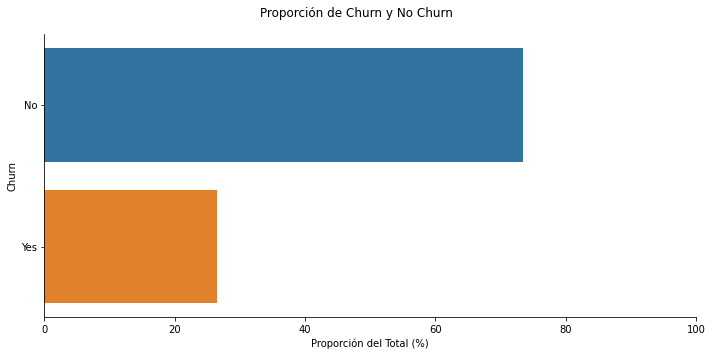

In [15]:
a=sns.catplot(x='porcentaje',y='churn', data=aux, kind='bar', orient='h', aspect=2)
a.fig.suptitle('Proporción de Churn y No Churn')
a.axes[0,0].set_xlabel('Proporción del Total (%)')
a.axes[0,0].set_ylabel('Churn')
a.set(xlim=(0,100))
plt.tight_layout()

Con esta gráfica se puede observar que menos de un tercio (26.58%) de los clientes de Telco dejan la empresa, es decir, hacen churn. Por lo tanto, la mayoría de los clientes (73.42%) están satisfechos con los servicios ofrecidos por la empresa.

### Distribución de la variable *total_charges* por contract y churn

In [16]:
empresa.dtypes
out=empresa['total_charges'].apply(lambda col:pd.to_numeric(col, errors='coerce'))
out

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7027    1990.50
7028    7362.90
7029     346.45
7030     306.60
7031    6844.50
Name: total_charges, Length: 7032, dtype: float64

Text(0, 0.5, 'Contract')

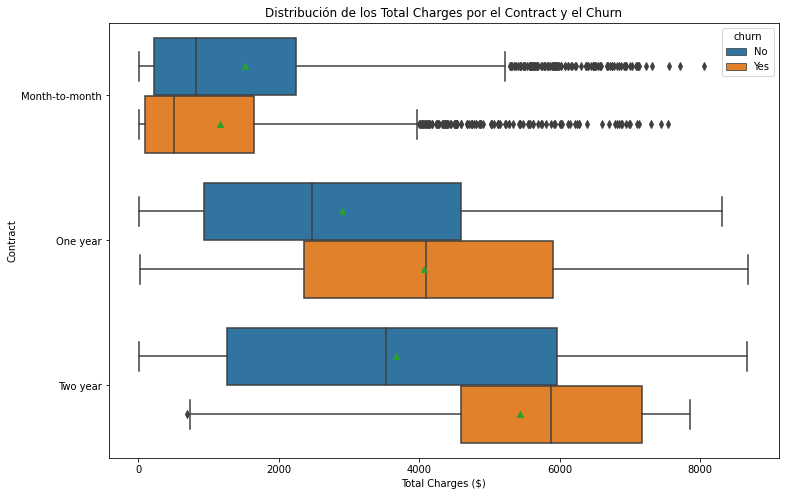

In [17]:
fig_dims=(12, 8)
fig, ax=plt.subplots(figsize=fig_dims)
sns.boxplot(data=empresa, x=out, y='contract', hue = 'churn', showmeans=True)\
.set_title("Distribución de los Total Charges por el Contract y el Churn")
plt.xlabel("Total Charges ($)")
plt.ylabel("Contract")

<p style='text-align: justify;'> 
    Para los clientes que tienen un contrato de mes-a-mes, los cargos totales que tienen son los más bajos de los tres tipos de contratos que existen. En general, la dispersión no es mucha y solo algunos casos pagan más de 3000 dólares sin importan que churneen o no. <br> <br>
    Por otro lado, los clientes que tienen un contrato de un año con la empresa tienen cargos totales más elevados que los de mes-a-mes. Dentro del subconjunto de un año, es notable que los clientes que churnean, muy probablemente, es debido a los cargos totales tan altos a comparación de los que no churnean. La dispersión en este subconjunto es más grande ya que los que no churnean tienen cargos totales de entre aproximadamente 1,000 y 4,500 dólares; mientras que los que sí churnean tienen de, aproximadamente, entre 2,300 y 5,800 dólares. <br> <br>
    Finalmente, de los clientes con contratos de dos años, se puede ver que los que no churnean han pagado cantidades dentro un rango muy grande, es decir que o acumularon muy poquito (aproximadamente 1,500 dólares) o pueden llegar a tener cargos muy elevados (6,000 dólares aproximadamente). Sin embargo, al igual que los clientes con contrato de un año, los que se van tienen cargos totales mucho más elevados y menos dispersos que los que permanecen. <br> <br> 
</p>

### Distribución de la variable *monthly_charges* por contract y churn

Text(0, 0.5, 'Contract')

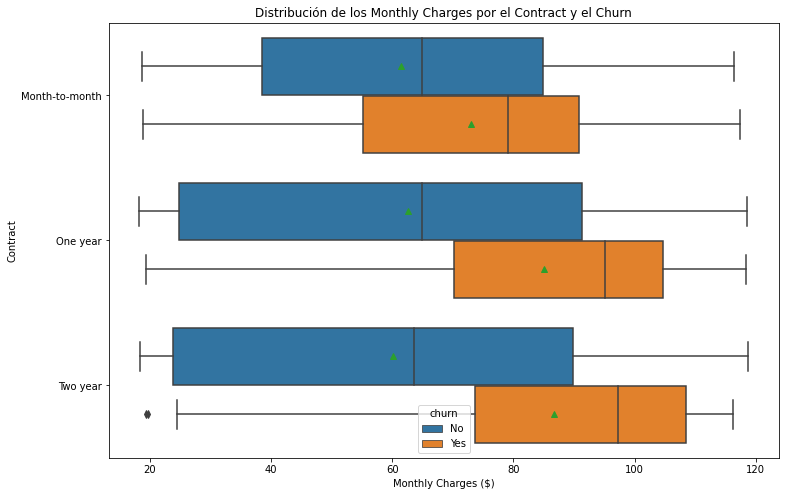

In [18]:
fig_dims=(12, 8)
fig, ax=plt.subplots(figsize=fig_dims)
sns.boxplot(data=empresa, x='monthly_charges', y='contract', hue = 'churn', showmeans=True)\
.set_title("Distribución de los Monthly Charges por el Contract y el Churn")
plt.xlabel("Monthly Charges ($)")
plt.ylabel("Contract")

<p style='text-align: justify;'>
    En la gráfica podemos observar que para los tres tipos de contratos, los cargos mensuales de los clientes que no hacen churn tienen más dispersión.<br> <br>
De los clientes que <i>no churnean</i>, los cargos mensuales promedio son similares en los 3 tipos de contrato, siendo el de dos años el más bajo y el de un año el más alto pero por muy poco. No se encontraron datos atípicos para este subconjunto. El 50% de los clientes que no churnean pagan entre 65 y 70 dólares máximo al mes. <br> <br>
    Para los clientes que <i>sí churnean</i>, podemos observar que el cargo mensual promedio es mayor que el de los que no churnean. El más alto es el de dos años, segudido por el de un año y luego el de mes a mes. Para el contrato de dos años se consideraron atípicos las observaciones que tuvieran cargos mensuales de menos de 25 dólares. El 50% de los clientes que churnearon pagaban aproximadamente 95 dólares máximo al mes en caso de los contratos de uno y dos años, y casi 80 dólares máximo en el caso de los de mes a mes.<br> <br> 
    Como se mencionó en la gráfica anterior, los cargos elevados pueden ser un factor importante para detectar si un cliente va a churnear.
</p>

### Distribución de la variable monthlycharges por paymentmethod y churn

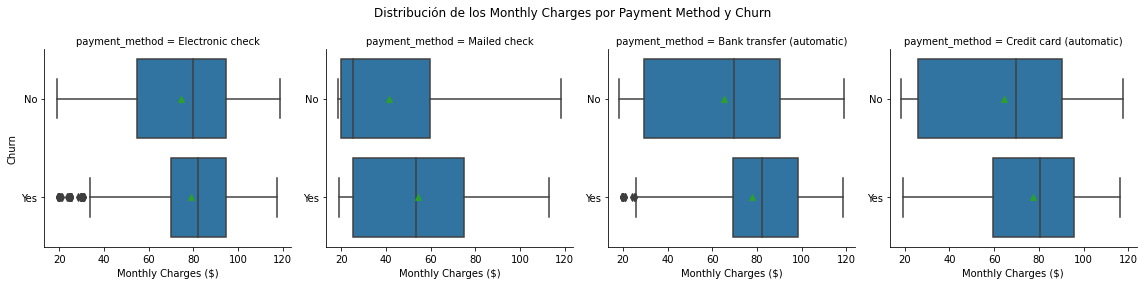

In [19]:
d=sns.FacetGrid(empresa, col='payment_method', aspect=1, height=4, sharey=False)
d.map_dataframe(sns.boxplot, x="monthly_charges", y="churn", showmeans=True)
d.fig.suptitle('Distribución de los Monthly Charges por Payment Method y Churn')
d.axes[0,0].set_xlabel('Monthly Charges ($)')
d.axes[0,1].set_xlabel('Monthly Charges ($)')
d.axes[0,2].set_xlabel('Monthly Charges ($)')
d.axes[0,3].set_xlabel('Monthly Charges ($)')
d.axes[0,0].set_ylabel('Churn')
plt.tight_layout()

<p style='text-align: justify;'> 
    Para los clientes que pagan mediante un cheque electrónico, los cargos mensuales de los clientes que no churnean son más dispersos que los cargos de los que sí churnean. Los clientes que churnean y tienen cargos mensuales de menos de 35 dólares son considerados atípicos. El cargo mensual promedio para este método de pago es de 75 dólares para los que no churnean y casi 80 dólares para los que sí. El 75% de los clientes pagan 95 dólares máximo al mes.<br> <br>
    Con el método de pago de cheque por correo, los clientes que sí churnearon, pagaban en promedio cerca de 55 dólares al mes, mientras que los que no churnearon, el promedio es de 40 dólares. El 50% de los clientes que no churnearon pagaban 25 dólares al mes o menos, mientras que los que sí churnearon cerca de 55 dólares. <br> <br>
    Los clientes que pagaron su servicio con el método de transferencia bancaria, los cargos mensuales de los que no churnearon son más dispersos que los que sí. En promedio los que no churnearon pagan 65 dólares al mes, mientras que los que sí, pagaban 75 dólares al mes en promedio. Aquellos que pagaban menos de 25 al mes y churnearon son considerados atípicos. El 25% de los clientes que churnearon pagaban 60 dólares o menos, mientras que los que no churnearon el 25% paga 30 dólares o menos. <br> <br>
    Con pago con tarjeta de crédito, los cargos mensuales siguen siendo más dispersos para los clientes que no churnearon. El promedio es de 65 dólares al mes para clientes que no churnearon y casi 80 dólares para los que sí. El 25% de los clientes que no churnearon pagan 25 dólares o menos, mientras que el 25% de los clientes que sí churnearon tenían cargos mensuales de 60 dólares. <br> <br>
    Independientemente del método de pago, seguimos observando que los cargos mensuales altos son consistentes en los clientes que churnearon, y que también la concentración de los datos igual está en cifras elevadas. El método que tiene más dispersión dentro de los clientes que sí churnearon fue el cheque por correo, por lo que la seguridad o eficiencia de ese método puede ser un factor al predecir si va a churnear o no.
</p>

## Preprocesamiento

Cambiamos las variables gender, seniorcitizen, partner, phoneservice, paperlessbilling y churn a variables binarias con valor posible 0 para el caso No y 1 para el caso Yes.

In [20]:
empresa.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [21]:
# Cambia los "Yes" a 1s y los "No" a 0s (Excepto gender en el que "Female" es 1 y "Male" es 0)
empresa["gender"].replace({"Female": 1, "Male": 0}, inplace = True)
empresa["partner"].replace({"Yes": 1, "No": 0}, inplace = True)
empresa["phone_service"].replace({"Yes": 1, "No": 0}, inplace = True)
empresa["paperless_billing"].replace({"Yes": 1, "No": 0}, inplace = True)
empresa["churn"].replace({"Yes": 1, "No": 0}, inplace = True)
empresa["dependents"].replace({"Yes": 1, "No": 0}, inplace = True)

In [22]:
empresa.groupby(['multiple_lines']).count() 

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
multiple_lines,,,,,,,,,,,,,,,,,,,,
No,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385
No phone service,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680
Yes,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967


Transformamos las variables a una codificación de one hot encoding: multiplelines, internetservice, onlinesecurity, onlinebackup, deviceprotection, techsupport, streamingtv, streamingmovies, contract, paymentmethod.

In [23]:
from sklearn.preprocessing import OneHotEncoder

In [24]:
ohe = OneHotEncoder()
ohe_df = pd.DataFrame()

In [25]:
ohe_var = ["multiple_lines", "internet_service", "online_security", "online_backup", "device_protection", 
           "tech_support", "streaming_tv", "streaming_movies", "contract", "payment_method"]

In [26]:
for i in range(len(ohe_var)):
    columna = ohe_var[i]
    ohe_ = ohe.fit_transform(empresa[columna].values.reshape(-1,1))
    df_ohe = pd.DataFrame(list(ohe_.toarray()), columns = columna + "_" + empresa[columna].unique())
    ohe_df = pd.merge(df_ohe, ohe_df, how="left", left_index = True, right_index = True)

In [27]:
ohe_df.head()

,payment_method_Electronic check,payment_method_Mailed check,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),contract_Month-to-month,contract_One year,contract_Two year,streaming_movies_No,streaming_movies_Yes,streaming_movies_No internet service,...,online_backup_No internet service,online_security_No,online_security_Yes,online_security_No internet service,internet_service_DSL,internet_service_Fiber optic,internet_service_No,multiple_lines_No phone service,multiple_lines_No,multiple_lines_Yes
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [28]:
empresa = empresa.drop(ohe_var, axis = 1)

In [29]:
empresa = pd.concat([empresa, ohe_df], axis=1)

In [30]:
empresa.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,paperless_billing,monthly_charges,total_charges,...,online_backup_No internet service,online_security_No,online_security_Yes,online_security_No internet service,internet_service_DSL,internet_service_Fiber optic,internet_service_No,multiple_lines_No phone service,multiple_lines_No,multiple_lines_Yes
0,7590-VHVEG,1,0,1,0,1,0,1,29.85,29.85,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,5575-GNVDE,0,0,0,0,34,1,0,56.95,1889.5,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3668-QPYBK,0,0,0,0,2,1,1,53.85,108.15,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,7795-CFOCW,0,0,0,0,45,0,0,42.30,1840.75,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,9237-HQITU,1,0,0,0,2,1,1,70.70,151.65,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Modelado

In [31]:
np.random.seed(210418)

Se generan las variables:

In [32]:
# Variable target
y = empresa.churn
y.head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int64

In [33]:
# Variables para predecir
# Se quita la columna churn (es el target) y customer_id (causa conflicto en el árbol)
X = empresa.drop(['churn', 'customer_id'], axis = 1)
X.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,paperless_billing,monthly_charges,total_charges,payment_method_Electronic check,...,online_backup_No internet service,online_security_No,online_security_Yes,online_security_No internet service,internet_service_DSL,internet_service_Fiber optic,internet_service_No,multiple_lines_No phone service,multiple_lines_No,multiple_lines_Yes
0,1,0,1,0,1,0,1,29.85,29.85,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0,0,34,1,0,56.95,1889.5,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,0,0,0,2,1,1,53.85,108.15,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,0,0,0,45,0,0,42.30,1840.75,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1,0,0,0,2,1,1,70.70,151.65,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### Árbol de selección

Se hace la separación de entrenamiento

In [34]:
## separando en train, test 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## verificando los tamaños de nuestros 4 sets
print("entrenamiento: X: {}, y: {}".format(X_train.shape, y_train.shape))
print("prueba: X: {}, y: {}".format(X_test.shape, y_test.shape))

entrenamiento: X: (5274, 40), y: (5274,)
prueba: X: (1758, 40), y: (1758,)


Se configura el árbol:

In [35]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time

%matplotlib inline

grid = {'random_state': [5432], 'max_depth': [5, 7, 11], 'min_samples_leaf': [7, 9, 11, 13], 
        'criterion':['gini','entropy'] }

dt = DecisionTreeClassifier(random_state=5432)
gs_dt = GridSearchCV(dt, grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

start = time.time()
# Instanciaremos y entrenaremos el árbol con nuestros datos de entrenamiento
gs_dt.fit(X_train, y_train)
print("tiempo de ejecución en segundos: {}".format(time.time() - start))

tiempo de ejecución en segundos: 3.1574950218200684


Se generan **24 modelos**, es decir que se genera un modelo por cada combinación posible entre los parámetros dados. 

Por lo tanto: 1 x 3 x 4 x 2 = 24 modelos.

In [80]:
# mejor configuración 
importancias = gs_dt.best_estimator_.feature_importances_
importancias

array([0.01146319, 0.00914269, 0.0024823 , 0.00231267, 0.15592133,
       0.00339089, 0.01192543, 0.08460734, 0.07648416, 0.00411911,
       0.        , 0.01875197, 0.00195279, 0.43681937, 0.01941309,
       0.        , 0.        , 0.        , 0.01134441, 0.00165582,
       0.        , 0.        , 0.01218505, 0.        , 0.00268436,
       0.00358144, 0.        , 0.        , 0.00976768, 0.        ,
       0.        , 0.00354587, 0.        , 0.00726961, 0.        ,
       0.09906008, 0.        , 0.00298772, 0.00288108, 0.00425054])

In [81]:
# Índices de los más importantes (están ordenados de menor a mayor)
imp_3=np.argsort(importancias)[[-1, -2, -3]]
imp_3

array([13,  4, 35])

In [82]:
# Columnas importantes
X.columns[imp_3]

Index(['contract_Month-to-month', 'tenure', 'internet_service_Fiber optic'], dtype='object')

In [40]:
# Porcentaje de importancia de las columnas importantes
importancias[imp_3]

array([0.43681937, 0.15592133, 0.09906008])

Las tres variables más importantes para la predicción son si el cliente tiene un **contrato de mes-mes** (contract_Month-to-month) con 43.68% de importancia; la **tenencia** (tenure) con 15.59% de importancia; y si el cliente tiene **Internet por medio de fibra óptica** (internet_service_Fiber optic) con 9.90% de importancia.

In [41]:
# Variables que no importan
no_imp = np.where(importancias < 0.01)
var_no_imp = X.columns[no_imp]
var_no_imp

Index(['senior_citizen', 'partner', 'dependents', 'phone_service',
       'payment_method_Electronic check', 'payment_method_Mailed check',
       'payment_method_Credit card (automatic)', 'contract_Two year',
       'streaming_movies_No', 'streaming_movies_Yes', 'streaming_tv_No',
       'streaming_tv_Yes', 'streaming_tv_No internet service',
       'tech_support_Yes', 'tech_support_No internet service',
       'device_protection_No', 'device_protection_Yes',
       'device_protection_No internet service', 'online_backup_Yes',
       'online_backup_No', 'online_backup_No internet service',
       'online_security_No', 'online_security_Yes',
       'online_security_No internet service', 'internet_service_DSL',
       'internet_service_No', 'multiple_lines_No phone service',
       'multiple_lines_No', 'multiple_lines_Yes'],
      dtype='object')

In [42]:
X_train = X_train.drop(var_no_imp, axis = 1)
X_test = X_test.drop(var_no_imp, axis = 1)

In [43]:
X_train.head()

,gender,tenure,paperless_billing,monthly_charges,total_charges,payment_method_Bank transfer (automatic),contract_Month-to-month,contract_One year,streaming_movies_No internet service,tech_support_No,internet_service_Fiber optic
5512,0,59,1,64.65,3735.45,1.0,1.0,0.0,0.0,0.0,0.0
6471,1,13,0,53.45,718.1,0.0,1.0,0.0,0.0,0.0,0.0
615,0,8,1,25.25,186.3,0.0,1.0,0.0,0.0,1.0,0.0
2521,0,1,0,19.40,19.4,0.0,1.0,0.0,0.0,0.0,0.0
571,1,11,0,64.90,697.25,0.0,0.0,1.0,1.0,0.0,0.0


<p style='text-align: justify;'> 
En este momento se eliminan las variables que no aportan mucha información del x_train y x_test ya existentes, en vez de generar uno nuevo con las variables importantes. Esto es debido a que, si se quitan de la base original y se vuelven a separar en 25% para prueba y 75% para entrenamiento, como no se utilizó un random state, la separación resultante sería diferente a la que se usó para el primer árbol. Si estos nuevos x_train y x_test los usáramos para el Random Forest, le estaríamos pasando información adicional al modelo y habría data leakage, cosa que queremos evitar.
</p>

### Random Forest

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

import matplotlib.pyplot as plt
# n_estimators corresponde al número de árboles que queremos crear: 
grid = {'random_state': [7654], 'max_depth': [11, 13, 15], 'n_estimators': [500, 800, 1000], 
        'min_samples_leaf': [11, 13], 'criterion':['gini','entropy'] }

rf = RandomForestClassifier(oob_score=True, n_jobs=-1)
gs_rf = GridSearchCV(rf, grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

start = time.time()
# entrenando los random forest
gs_rf.fit(X_train, y_train)
print("tiempo de ejecución en segundos: {}".format(time.time() - start))

tiempo de ejecución en segundos: 171.04563188552856


Se generan **36 modelos**, es decir que se genera un modelo por cada combinación posible entre los parámetros dados. 

Por lo tanto: 1 x 3 x 3 x 2 x 2 = 36 modelos.

In [45]:
# mejor configuración 
importancias_rf = gs_rf.best_estimator_.feature_importances_
importancias_rf

array([0.01539166, 0.21149233, 0.0187374 , 0.14052376, 0.15820783,
       0.05401331, 0.1790763 , 0.01221336, 0.01474895, 0.09807617,
       0.09751894])

In [46]:
# Índice del más importantes (están ordenados de menor a mayor)
imp = np.argsort(importancias_rf)[-1]
imp

1

In [47]:
X_train.columns[imp]

'tenure'

In [48]:
importancias_rf[imp]

0.21149232577152874

La variable raíz para el modelo es **tenure** con un porcentaje de 21.14% de información proporcionada. Es decir, la permanencia de los clientes es la empresa es la variable que más información aporta a la hora de predecir si los clientes van a abandonar. 

Los hiperparámetros del mejor modelo son:
- Profundidad: 11
- Número de árboles: 800
- Definición de hoja: 11
- Ganancia de información: gini

In [49]:
# mejor configuración 
gs_rf.best_estimator_

RandomForestClassifier(max_depth=11, min_samples_leaf=11, n_estimators=800,
                       n_jobs=-1, oob_score=True, random_state=7654)

In [50]:
gs_rf.best_estimator_.criterion

'gini'

### Predicción

In [51]:
# predicciones con el mejor predictor 
predicted_labels = gs_rf.predict(X_test)
predicted_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [52]:
# predicciones en score con el mejor predictor
predicted_scores = gs_rf.predict_proba(X_test)
predicted_scores[:10]

array([[0.96106683, 0.03893317],
       [0.93862576, 0.06137424],
       [0.90224364, 0.09775636],
       [0.98454732, 0.01545268],
       [0.95631095, 0.04368905],
       [0.95760318, 0.04239682],
       [0.92032714, 0.07967286],
       [0.51301595, 0.48698405],
       [0.65670784, 0.34329216],
       [0.40340256, 0.59659744]])

### Curva ROC

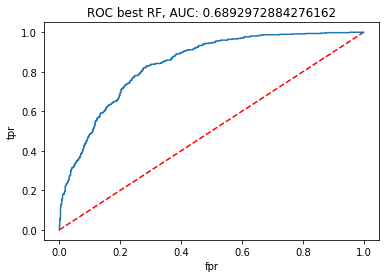

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

La curva ROC está por encima del ángulo de 45º y el AUC de nuestro modelo es de 0.6892. Entonces, existe un 68.92% de probabilidad de que el modelo sea capaz de distinguir una muestra positiva y una muestra negativa. Por lo tanto, basándonos únicamente en esta gráfica, podemos decir que el modelo tiene un buen desempeño para predecir qué clientes harán *churn*. Sin embargo, hace falta sacar otras métricas para complementar este resultado.

### Curva Precision-Recall

<Figure size 432x288 with 0 Axes>

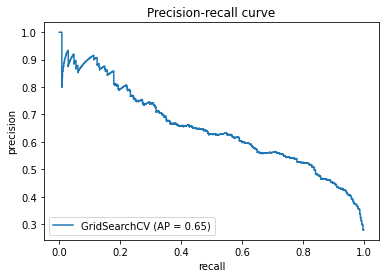

In [54]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)
thresholds_2 = np.append(thresholds_2, 1)
(precision.shape, recall.shape, thresholds_2.shape)

plt.clf()
plot_precision_recall_curve(gs_rf, X_test, y_test)
plt.title("Precision-recall curve")
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

Si se hace un corte en la gráfica en el 0.7 (70%) del eje de presición, podemos ver que aproximadamente hay un recall de 35%, es decir que de todas las posibles predicciones de la clase positiva, el 35% se identificaría correctamente. Por lo tanto, nos damos cuenta de que si se quiere una alta precisión, como censecuencia se tendrá un bajo recall, es decir que tienen un comportamiento inverso. Sin embargo, en el caso de Telco, como se comentó al principio del trabajo, se necesita un alto recall para minimizar los falsos negativos porque son los casos que le cuestan más a la empresa y eso genera que haya un bajo porcentaje de precisión.

### Métricas de desempeño

In [55]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [66]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.003646,0.279412,1.000000,0.436782,1.000000,0.954793,0.045207,0.000000
1,0.003750,0.278988,0.997895,0.436063,0.997895,0.954793,0.045207,0.002105
2,0.004493,0.281306,0.997895,0.438889,0.997895,0.943882,0.056118,0.002105
3,0.004524,0.281640,0.997895,0.439296,0.997895,0.942323,0.057677,0.002105
4,0.010219,0.296807,0.997895,0.457529,0.997895,0.875292,0.124708,0.002105
...,...,...,...,...,...,...,...,...
495,0.877622,0.875000,0.029474,0.057026,0.029474,0.001559,0.998441,0.970526
496,0.880179,0.933333,0.029474,0.057143,0.029474,0.000779,0.999221,0.970526
497,0.910049,0.800000,0.008421,0.016667,0.008421,0.000779,0.999221,0.991579
498,0.913722,1.000000,0.008421,0.016701,0.008421,0.000000,1.000000,0.991579


### Punto de corte

<p style='text-align: justify;'> 
De acuerdo al contexto del problema, nos piden que no puede haber más del 2% de errores de acuerdo a la etiqueta positiva, por lo que buscaremos que el porcentaje de Falsos Positivos sea menor a 2%.
</p>

In [57]:
negocio = metrics_report[metrics_report.fpr <= 0.02]
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
464,0.676066,0.807692,0.221053,0.347107,0.221053,0.019486,0.980514,0.778947
465,0.696396,0.788136,0.195789,0.313659,0.195789,0.019486,0.980514,0.804211
466,0.696604,0.794872,0.195789,0.314189,0.195789,0.018706,0.981294,0.804211
467,0.699427,0.793103,0.193684,0.311337,0.193684,0.018706,0.981294,0.806316
468,0.701504,0.807018,0.193684,0.312394,0.193684,0.017147,0.982853,0.806316
469,0.702336,0.803571,0.189474,0.306644,0.189474,0.017147,0.982853,0.810526
470,0.702812,0.810811,0.189474,0.307167,0.189474,0.016368,0.983632,0.810526
471,0.703675,0.805556,0.183158,0.298456,0.183158,0.016368,0.983632,0.816842
472,0.705099,0.813084,0.183158,0.298969,0.183158,0.015588,0.984412,0.816842
473,0.707630,0.809524,0.178947,0.293103,0.178947,0.015588,0.984412,0.821053


In [58]:
punto_corte = negocio.iloc[0].threshold
punto_corte

0.6760664948513613

<p style='text-align: justify;'> 
En el punto de corte, el threshold es de <b>0.676066</b>, es decir que para tener un 2% de errores o menos, se verificará que el score de la predicción hecha sea en menor o igual a ese número; si es menor entonces le pondremos la etiqueta 0, si es mayor entonces tendrá la etiqueta 1. <br> <br>
    En ese punto de corte se tiene un porcentaje de <i>recall</i> de 22.10%, es decir que de las posibles predicciones de la clase positiva, el 22.10% se identifican correctamente. Por otro lado, el porcentaje de <i>precisión</i> en el punto de corte es de 80.76%, es decir que de los que se identifican como clase positiva, el 80.76% se predijeron correctamente por lo que es un modelo eficiente.
</p>

In [59]:
new_labels = [0 if score < punto_corte else 1 for score in predicted_scores[:,1]]
new_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [60]:
pd.Series(new_labels).sum()

130

### Matriz de confusión

In [61]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predicted_labels)

array([[1161,  122],
       [ 250,  225]])

In [62]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, new_labels)

array([[1258,   25],
       [ 370,  105]])

De la siguiente matriz de confusión se puede ver que:
- El modelo tiene 105 aciertos en verdaderos positivos, es decir, clientes que churnearon y el modelo lo predijo correctamente.
- El modelo tiene 1258 aciertos en verdaderos negativos, es decir, clientes que no churnearon y el modelo lo predijo correctamente.
- El modelo tiene 25 falsos positivos, es decir, clientes que no churnearon y el modelo predijo erróneamente que lo iban a hacer.
- El modelo tiene 370 falsos negativos, es decir, clientes que churnearon y el modelo predijo erróneamente que no lo iban a hacer. 
- El modelo tiene 1,363 aciertos y 395 errores de predicción.


El modelo y la predicción lograron optimizar el _recall_ y minimizar los falsos negativos hasta ese nivel, dado el contexto y las indicaciones de Telco.

In [67]:
tp=105
tn=1258
fp=25
fn=370

acc=(tp+tn)/(tp+fp+tn+fn)
acc

0.7753128555176336

In [68]:
prec=tp/(tp+fp)
prec

0.8076923076923077

In [69]:
rec=tp/(tp+fn)
rec

0.22105263157894736

La predicción tuvo un _accuracy_ de 77.53%, un _precision_ de 80.76% y un _recall_ de 22.10%, consistente con lo obtenido en la tabla de métricas. El modelo también fue consistente con el trade-off entre _precision_ y _recall_ visto en la curva ROC.